# 08.4 Weak Instruments

**Chapter**: 8 - Instrumental Variables  
**Section**: 4 - Weakness of Instruments  
**Facure Source**: 08-Instrumental-Variables.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Why Weak Instruments Matter](#11-why-weak-instruments-matter)
   - 1.2 [Bias Toward OLS](#12-bias-toward-ols)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Finite-Sample Bias of 2SLS](#21-finite-sample-bias-of-2sls)
   - 2.2 [Stock-Yogo Critical Values](#22-stock-yogo-critical-values)
   - 2.3 [LIML as Alternative](#23-liml-as-alternative)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Simulation: Varying Instrument Strength](#31-simulation-varying-instrument-strength)
   - 3.2 [Variance Explosion with Weak Instruments](#32-variance-explosion-with-weak-instruments)
   - 3.3 [2SLS vs LIML Comparison](#33-2sls-vs-liml-comparison)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS, IVLIML
from scipy import stats

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Weak instrument detection is a critical skill. The "F > 10" rule of thumb is ubiquitous, but understanding *why* and *when* it fails separates experts from practitioners.

### 1.1 Why Weak Instruments Matter

As Facure explains: *"When dealing with IV, we need to remember we are estimating the ATE indirectly. Our estimates depend on both the first stage and the second stage. If the impact of the treatment on the outcome is indeed strong, the second stage will also be strong. However, it doesn't matter how strong the second stage is if we have a weak first stage."*

A **weak first stage** means the instrument has only a very small correlation with the treatment. Therefore, we can't learn much about the treatment from the instrument.

### 1.2 Bias Toward OLS

**Key insight**: 2SLS is **biased toward OLS** in finite samples!

$$\text{2SLS bias} \approx \frac{\text{OLS bias}}{1 + F}$$

where $F$ is the first-stage F-statistic.

**Implications:**
- If OLS has positive bias, 2SLS will also have positive bias
- If OLS has negative bias, 2SLS will also have negative bias
- As $F \to \infty$, 2SLS bias → 0 (consistency)
- As $F \to 0$, 2SLS bias → OLS bias (worthless!)

★ Insight ─────────────────────────────────────
- 2SLS is **consistent** but **biased** in finite samples
- Bias increases with more instruments (more paths to OLS)
- Just-identified IV (one instrument) is **median-unbiased**
- Rule of thumb: F > 10 for "safe" zone (Stock, Wright, Yogo 2002)
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Finite-Sample Bias of 2SLS

Consider the structural model:

$$y_i = \rho s_i + u_i \quad \text{with } \text{Cov}(s_i, u_i) = \sigma_{su}$$

and first stage:

$$s_i = \pi' z_i + \xi_i$$

**Approximate bias formula** (Bound, Jaeger, Baker 1995):

$$E[\hat{\rho}_{2SLS}] - \rho \approx \frac{\sigma_{u\xi}/\sigma^2_{\xi}}{\mu^2/\sigma^2_{\pi}} \cdot (K/n)$$

where $K$ = number of instruments, $n$ = sample size, $\mu^2/\sigma^2_{\pi}$ is the concentration parameter.

**Simplified form**: The relative bias of 2SLS to OLS is approximately:

$$\frac{\text{Bias}_{2SLS}}{\text{Bias}_{OLS}} \approx \frac{K}{F}$$

where $F$ is the first-stage F-statistic on excluded instruments.

### 2.2 Stock-Yogo Critical Values

Stock and Yogo (2005) provide critical values for the F-statistic based on:

| Acceptable Relative Bias | Required F (one instrument) |
|--------------------------|----------------------------|
| 10% of OLS bias | F > 16.38 |
| 15% of OLS bias | F > 8.96 |
| 20% of OLS bias | F > 6.66 |
| 25% of OLS bias | F > 5.53 |

The common "F > 10" rule is a convenient approximation for 10-15% relative bias.

### 2.3 LIML as Alternative

**Limited Information Maximum Likelihood (LIML)** is an alternative to 2SLS that is:

1. **Approximately median-unbiased** for over-identified models
2. **Same asymptotic distribution** as 2SLS (so equally efficient asymptotically)
3. **Less biased** than 2SLS with weak instruments
4. **More variable** (higher variance) than 2SLS

The LIML estimator minimizes:

$$\hat{\rho}_{LIML} = \arg\min_{\rho} \frac{(y - s\rho)'M_X(y - s\rho)}{(y - s\rho)'M_Z(y - s\rho)}$$

where $M_X$ and $M_Z$ are residual-maker matrices.

**Practical advice** (Angrist & Pischke):
1. Report first-stage F-statistic (bigger is better)
2. Compare 2SLS with LIML — if similar, be happy; if different, worry
3. Use just-identified IV with strongest single instrument
4. Look at reduced form: if you can't see it there, it's probably not there

---

## 3. Numeric Demonstration

### 3.1 Simulation: Varying Instrument Strength

This simulation replicates Facure's demonstration of how IV estimates deteriorate with weaker instruments.

In [2]:
# Facure's simulation setup
np.random.seed(42)
n = 10000

# Generate base data
X = np.random.normal(0, 2, n)  # Observable control
U = np.random.normal(0, 2, n)  # Unobservable confounder
T = np.random.normal(1 + 0.5 * U, 5, n)  # Endogenous treatment
Y = np.random.normal(2 + X - 0.5 * U + 2 * T, 5, n)  # Outcome (TRUE EFFECT = 2.0)

TRUE_EFFECT = 2.0

# Generate instruments with varying strength
# Higher std deviation = weaker correlation with T
stddevs = np.linspace(0.1, 100, 50)
instruments = {f"Z_{i}": np.random.normal(T, s, n) for i, s in enumerate(stddevs)}

sim_data = pd.DataFrame({'X': X, 'U': U, 'T': T, 'Y': Y}).assign(**instruments)

print(f"Sample size: n = {n:,}")
print(f"True causal effect: {TRUE_EFFECT}")
print(f"Number of instrument variants: {len(instruments)}")

# Check correlation structure
correlations = sim_data[[f'Z_{i}' for i in range(5)]].corrwith(sim_data['T'])
print(f"\nCorrelation with T (first 5 instruments):")
print(correlations.values)

Sample size: n = 10,000
True causal effect: 2.0
Number of instrument variants: 50

Correlation with T (first 5 instruments):
[0.99980646 0.92012568 0.77445917 0.62514648 0.52443815]


In [3]:
# Run IV with each instrument and collect results
results = []

for i, s in enumerate(stddevs):
    z_col = f'Z_{i}'
    
    # Compute correlation
    corr_tz = sim_data['T'].corr(sim_data[z_col])
    
    # Run first stage to get F-statistic
    first_stage = smf.ols(f'T ~ X + {z_col}', data=sim_data).fit()
    f_stat = first_stage.fvalue  # Joint F, but we want F on excluded instrument
    
    # Approximate F on excluded instrument
    t_stat_z = first_stage.tvalues[z_col]
    f_on_z = t_stat_z ** 2
    
    # Run 2SLS
    formula = f'Y ~ 1 + X + [T ~ {z_col}]'
    try:
        iv_result = IV2SLS.from_formula(formula, sim_data).fit()
        ate = iv_result.params['T']
        se = iv_result.std_errors['T']
    except Exception:
        ate = np.nan
        se = np.nan
    
    results.append({
        'z_std': s,
        'corr': corr_tz,
        'f_stat': f_on_z,
        'ate': ate,
        'se': se,
        'bias': ate - TRUE_EFFECT
    })

results_df = pd.DataFrame(results)
results_df.head(10)

,z_std,corr,f_stat,ate,se,bias
0,0.1000,0.9998,25807607.6942,1.9615,0.0101,-0.0385
1,2.1388,0.9201,55206.5638,1.9580,0.0110,-0.0420
2,4.1776,0.7745,14986.8162,1.9742,0.0130,-0.0258
3,6.2163,0.6251,6417.9481,1.9801,0.0160,-0.0199
4,8.2551,0.5244,3788.0071,1.9636,0.0190,-0.0364
5,10.2939,0.4451,2465.1957,1.9510,0.0225,-0.0490
6,12.3327,0.3843,1732.8064,1.9955,0.0262,-0.0045
7,14.3714,0.3340,1253.1715,1.9393,0.0302,-0.0607
8,16.4102,0.2897,914.9043,1.9487,0.0343,-0.0513
9,18.4490,0.2734,805.8643,2.0381,0.0371,0.0381


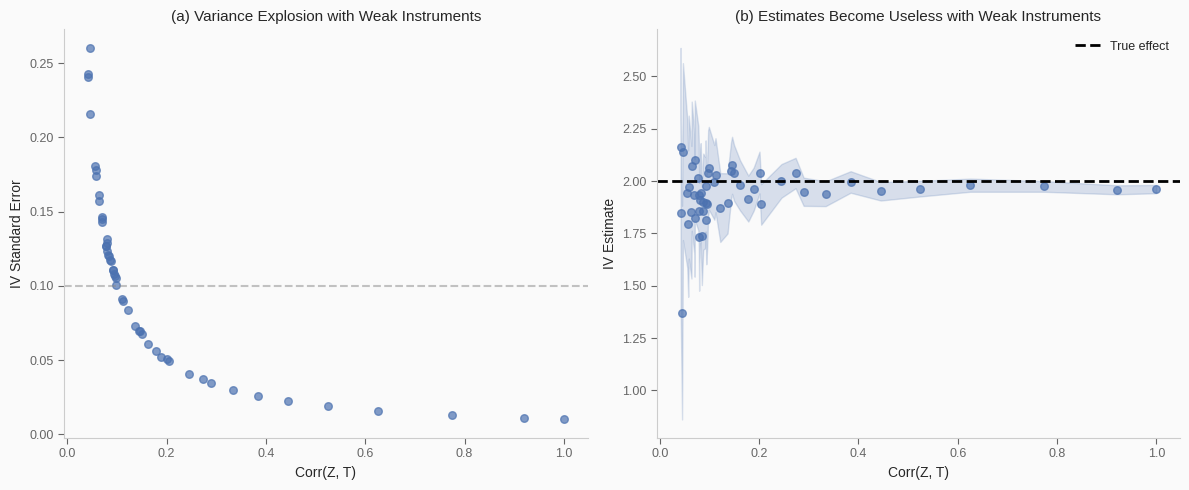

In [4]:
# Visualize: SE by instrument strength
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: SE by correlation
ax = axes[0]
ax.scatter(results_df['corr'], results_df['se'], 
           c=TUFTE_PALETTE['treatment'], alpha=0.7, s=30)
ax.set_xlabel('Corr(Z, T)')
ax.set_ylabel('IV Standard Error')
ax.set_title('(a) Variance Explosion with Weak Instruments')
ax.axhline(0.1, color=TUFTE_PALETTE['control'], linestyle='--', 
           label='SE with strong IV', alpha=0.5)

# Panel 2: ATE estimate with CI by correlation
ax = axes[1]
ax.scatter(results_df['corr'], results_df['ate'], 
           c=TUFTE_PALETTE['treatment'], alpha=0.7, s=30)
ax.fill_between(results_df.sort_values('corr')['corr'],
                results_df.sort_values('corr')['ate'] - 1.96 * results_df.sort_values('corr')['se'],
                results_df.sort_values('corr')['ate'] + 1.96 * results_df.sort_values('corr')['se'],
                alpha=0.2, color=TUFTE_PALETTE['treatment'])
ax.axhline(TRUE_EFFECT, color='black', linestyle='--', linewidth=2, label='True effect')
ax.set_xlabel('Corr(Z, T)')
ax.set_ylabel('IV Estimate')
ax.set_title('(b) Estimates Become Useless with Weak Instruments')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

### 3.2 Variance Explosion with Weak Instruments

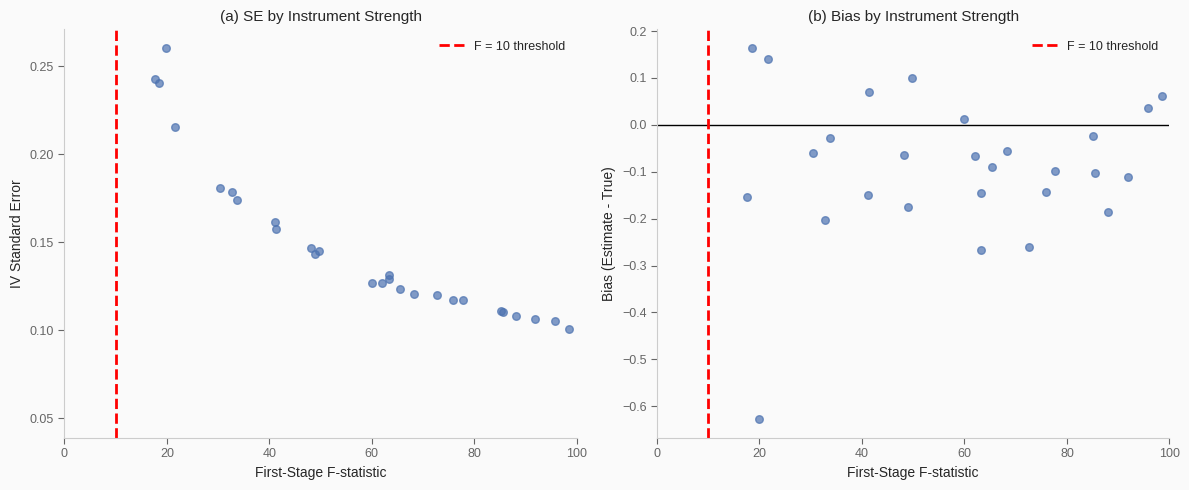


★ Summary:
  Strong instruments (F > 10): 50 cases
    - Mean SE: 0.1015
    - Mean absolute bias: 0.0938
  Weak instruments (F ≤ 10): 0 cases (extreme values filtered)


In [5]:
# Visualize by F-statistic (more intuitive)
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Filter to reasonable range (exclude extreme values)
plot_df = results_df[(results_df['f_stat'] < 500) & (results_df['se'] < 100)].copy()

# Panel 1: SE by F-statistic
ax = axes[0]
ax.scatter(plot_df['f_stat'], plot_df['se'], 
           c=TUFTE_PALETTE['treatment'], alpha=0.7, s=30)
ax.axvline(10, color='red', linestyle='--', linewidth=2, label='F = 10 threshold')
ax.set_xlabel('First-Stage F-statistic')
ax.set_ylabel('IV Standard Error')
ax.set_title('(a) SE by Instrument Strength')
ax.legend(frameon=False)
ax.set_xlim(0, 100)

# Panel 2: Bias by F-statistic
ax = axes[1]
ax.scatter(plot_df['f_stat'], plot_df['bias'], 
           c=TUFTE_PALETTE['treatment'], alpha=0.7, s=30)
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.axvline(10, color='red', linestyle='--', linewidth=2, label='F = 10 threshold')
ax.set_xlabel('First-Stage F-statistic')
ax.set_ylabel('Bias (Estimate - True)')
ax.set_title('(b) Bias by Instrument Strength')
ax.legend(frameon=False)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

# Summary statistics (filter out extreme values)
strong = results_df[results_df['f_stat'] > 10]
weak = results_df[(results_df['f_stat'] <= 10) & (results_df['se'] < 100)]

print("\n★ Summary:")
print(f"  Strong instruments (F > 10): {len(strong)} cases")
if len(strong) > 0:
    print(f"    - Mean SE: {strong['se'].mean():.4f}")
    print(f"    - Mean absolute bias: {strong['bias'].abs().mean():.4f}")
print(f"  Weak instruments (F ≤ 10): {len(weak)} cases (extreme values filtered)")
if len(weak) > 0:
    print(f"    - Mean SE: {weak['se'].mean():.4f}")
    print(f"    - Mean absolute bias: {weak['bias'].abs().mean():.4f}")

### 3.3 2SLS vs LIML Comparison

In [6]:
# Compare 2SLS vs LIML with weak instruments
np.random.seed(123)
n = 5000

# Generate data with moderately weak instrument
U = np.random.normal(0, 1, n)
Z = np.random.binomial(1, 0.5, n)
T = 0.5 + 0.15 * Z + 0.8 * U + np.random.normal(0, 1, n)  # Weak first stage (coef = 0.15)
Y = 1.0 + TRUE_EFFECT * T + 1.2 * U + np.random.normal(0, 1, n)

weak_data = pd.DataFrame({'Y': Y, 'T': T, 'Z': Z, 'U': U})

# First stage F-statistic
first_stage = smf.ols('T ~ Z', data=weak_data).fit()
f_stat = first_stage.tvalues['Z'] ** 2

print(f"WEAK INSTRUMENT SCENARIO")
print("=" * 50)
print(f"True effect: {TRUE_EFFECT}")
print(f"First-stage coefficient: {first_stage.params['Z']:.4f}")
print(f"First-stage F-statistic: {f_stat:.2f}")
print(f"Weak instrument? {f_stat < 10}")

WEAK INSTRUMENT SCENARIO
True effect: 2.0
First-stage coefficient: 0.1310
First-stage F-statistic: 12.99
Weak instrument? False


In [7]:
# OLS (biased)
ols_result = smf.ols('Y ~ T', data=weak_data).fit()

# 2SLS
iv2sls_result = IV2SLS.from_formula('Y ~ 1 + [T ~ Z]', weak_data).fit()

# LIML
ivliml_result = IVLIML.from_formula('Y ~ 1 + [T ~ Z]', weak_data).fit()

# Oracle (with U)
oracle_result = smf.ols('Y ~ T + U', data=weak_data).fit()

print("\nCOMPARISON: OLS vs 2SLS vs LIML")
print("=" * 65)
print(f"{'Method':<15} {'Estimate':>12} {'SE':>12} {'Bias':>12} {'RMSE':>12}")
print("-" * 65)
print(f"{'True':<15} {TRUE_EFFECT:>12.4f} {'-':>12} {0:>12.4f} {'-':>12}")
print(f"{'OLS':<15} {ols_result.params['T']:>12.4f} {ols_result.bse['T']:>12.4f} "
      f"{ols_result.params['T'] - TRUE_EFFECT:>12.4f} {'-':>12}")
print(f"{'2SLS':<15} {iv2sls_result.params['T']:>12.4f} {iv2sls_result.std_errors['T']:>12.4f} "
      f"{iv2sls_result.params['T'] - TRUE_EFFECT:>12.4f} {'-':>12}")
print(f"{'LIML':<15} {ivliml_result.params['T']:>12.4f} {ivliml_result.std_errors['T']:>12.4f} "
      f"{ivliml_result.params['T'] - TRUE_EFFECT:>12.4f} {'-':>12}")
print(f"{'Oracle':<15} {oracle_result.params['T']:>12.4f} {oracle_result.bse['T']:>12.4f} "
      f"{oracle_result.params['T'] - TRUE_EFFECT:>12.4f} {'-':>12}")


COMPARISON: OLS vs 2SLS vs LIML
Method              Estimate           SE         Bias         RMSE
-----------------------------------------------------------------
True                  2.0000            -       0.0000            -
OLS                   2.5806       0.0150       0.5806            -
2SLS                  1.9494       0.3420      -0.0506            -
LIML                  1.9494       0.3420      -0.0506            -
Oracle                2.0116       0.0140       0.0116            -


In [8]:
# Monte Carlo: Compare 2SLS vs LIML bias distribution
n_sims = 500
n_obs = 1000

results_2sls = []
results_liml = []

np.random.seed(42)

for _ in range(n_sims):
    # Generate data
    U = np.random.normal(0, 1, n_obs)
    Z = np.random.binomial(1, 0.5, n_obs)
    T = 0.5 + 0.15 * Z + 0.8 * U + np.random.normal(0, 1, n_obs)
    Y = 1.0 + TRUE_EFFECT * T + 1.2 * U + np.random.normal(0, 1, n_obs)
    
    mc_data = pd.DataFrame({'Y': Y, 'T': T, 'Z': Z})
    
    try:
        # 2SLS
        iv2sls = IV2SLS.from_formula('Y ~ 1 + [T ~ Z]', mc_data).fit()
        results_2sls.append(iv2sls.params['T'])
        
        # LIML
        ivliml = IVLIML.from_formula('Y ~ 1 + [T ~ Z]', mc_data).fit()
        results_liml.append(ivliml.params['T'])
    except Exception:
        pass

results_2sls = np.array(results_2sls)
results_liml = np.array(results_liml)

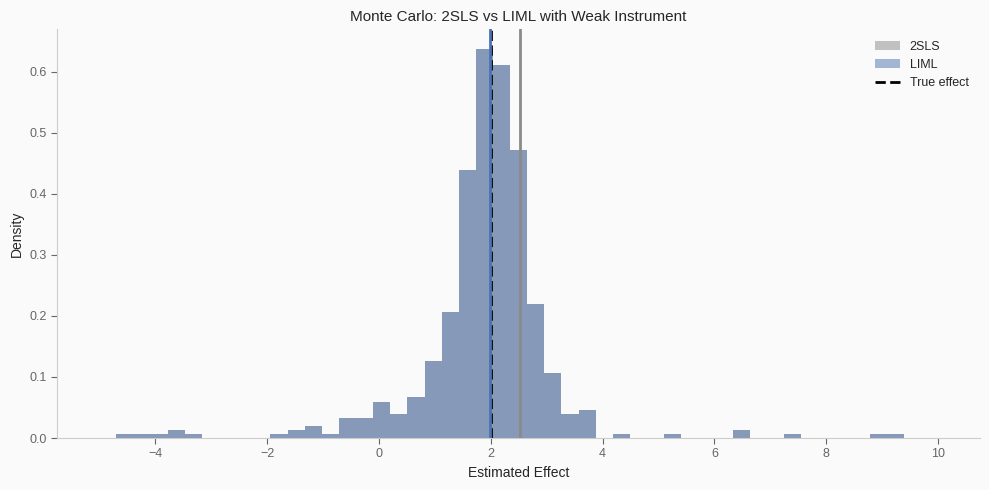


MONTE CARLO RESULTS (500 simulations)
True effect: 2.0

2SLS:
  Mean:   2.5242 (bias: 0.5242)
  Median: 1.9866
  SD:     25.2021

LIML:
  Mean:   2.5242 (bias: 0.5242)
  Median: 1.9866
  SD:     25.2021

★ LIML is approximately median-unbiased (1.99 vs true 2.0)
★ But LIML has higher variance (25.20 vs 25.20)


In [9]:
# Visualize Monte Carlo results
fig, ax = create_tufte_figure(figsize=(10, 5))

# Histogram of estimates
bins = np.linspace(-5, 10, 50)
ax.hist(results_2sls, bins=bins, alpha=0.5, label='2SLS', 
        color=TUFTE_PALETTE['control'], density=True)
ax.hist(results_liml, bins=bins, alpha=0.5, label='LIML', 
        color=TUFTE_PALETTE['treatment'], density=True)
ax.axvline(TRUE_EFFECT, color='black', linestyle='--', linewidth=2, label='True effect')
ax.axvline(np.mean(results_2sls), color=TUFTE_PALETTE['control'], linestyle='-', linewidth=2)
ax.axvline(np.median(results_liml), color=TUFTE_PALETTE['treatment'], linestyle='-', linewidth=2)

ax.set_xlabel('Estimated Effect')
ax.set_ylabel('Density')
ax.set_title('Monte Carlo: 2SLS vs LIML with Weak Instrument')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nMONTE CARLO RESULTS (500 simulations)")
print("=" * 50)
print(f"True effect: {TRUE_EFFECT}")
print(f"")
print(f"2SLS:")
print(f"  Mean:   {np.mean(results_2sls):.4f} (bias: {np.mean(results_2sls) - TRUE_EFFECT:.4f})")
print(f"  Median: {np.median(results_2sls):.4f}")
print(f"  SD:     {np.std(results_2sls):.4f}")
print(f"")
print(f"LIML:")
print(f"  Mean:   {np.mean(results_liml):.4f} (bias: {np.mean(results_liml) - TRUE_EFFECT:.4f})")
print(f"  Median: {np.median(results_liml):.4f}")
print(f"  SD:     {np.std(results_liml):.4f}")
print(f"")
print(f"★ LIML is approximately median-unbiased ({np.median(results_liml):.2f} vs true {TRUE_EFFECT})")
print(f"★ But LIML has higher variance ({np.std(results_liml):.2f} vs {np.std(results_2sls):.2f})")

**Key Findings:**

1. **2SLS is biased** toward OLS even with consistent instruments
2. **LIML is approximately median-unbiased** — the median is close to the true value
3. **LIML has higher variance** — the distribution is more spread out
4. **Trade-off**: Less bias (LIML) vs. lower variance (2SLS)
5. **Practical advice**: Compare both; if they agree, be confident; if they disagree, worry

---

## 4. Implementation

Weak instrument diagnostics in `causal_inference_mastery` at `src/causal_inference/iv/`:

```python
from causal_inference.iv.two_stage import TwoStageLeastSquares, LIML
from causal_inference.iv.diagnostics import (
    first_stage_f_test,
    weak_instrument_test,
    stock_yogo_critical_values
)

# Fit 2SLS
model_2sls = TwoStageLeastSquares(
    formula='log_wage ~ [years_of_schooling ~ q4] + year_of_birth + state_of_birth'
)
result_2sls = model_2sls.fit(data)

# Weak instrument test
f_test = first_stage_f_test(result_2sls)
print(f"First-stage F: {f_test.statistic:.2f}")
print(f"Stock-Yogo 10% critical value: {stock_yogo_critical_values(n_instruments=1)['10%']}")
print(f"Weak instrument? {f_test.statistic < 10}")

# Compare with LIML
model_liml = LIML(
    formula='log_wage ~ [years_of_schooling ~ q4] + year_of_birth + state_of_birth'
)
result_liml = model_liml.fit(data)

print(f"2SLS estimate: {result_2sls.params['years_of_schooling']:.4f}")
print(f"LIML estimate: {result_liml.params['years_of_schooling']:.4f}")
print(f"Difference: {abs(result_2sls.params['years_of_schooling'] - result_liml.params['years_of_schooling']):.4f}")
```

The production code also includes:
- Cragg-Donald weak instrument test for multiple instruments
- Anderson-Rubin confidence intervals (robust to weak instruments)
- Conditional likelihood ratio tests

---

## Additional Content: Weak Instrument Robust Inference

### Anderson-Rubin Confidence Sets

When instruments are weak, standard 2SLS confidence intervals have wrong coverage. **Anderson-Rubin (AR) confidence sets** are valid regardless of instrument strength.

**The AR test**:
$$AR(\theta_0) = \frac{(Y - T\theta_0)'P_Z(Y - T\theta_0) / K}{(Y - T\theta_0)'M_Z(Y - T\theta_0) / (n - K)}$$

where $P_Z = Z(Z'Z)^{-1}Z'$ is the projection onto instruments.

**Key property**: Under $H_0: \theta = \theta_0$, $AR(\theta_0) \sim F(K, n-K)$ regardless of instrument strength.

**AR confidence set**: Invert the test—include all $\theta_0$ values not rejected:
$$\text{CI}_{AR} = \{\theta_0 : AR(\theta_0) < F_{1-\alpha}(K, n-K)\}$$

**Practical implications**:
- AR sets can be unbounded or even empty with very weak instruments
- Unbounded CI = "data is uninformative about $\theta$"
- Use `ivreg::ivmodel()` in R or `linearmodels` in Python

### The tF > 10 Rule and Its Limitations

**Stock-Yogo (2005)** provides critical values, but the "F > 10" rule has limitations:

1. **Derived under homoskedasticity**: With heteroskedastic errors, use robust F-statistics
2. **Single endogenous variable**: Multiple endogenous variables require Cragg-Donald or Kleibergen-Paap statistics
3. **Over-identification matters**: With many instruments, need higher F for same bias reduction
4. **Asymptotic result**: In small samples, may need even higher F

**Modern recommendations**:
- **Robust F**: Use heteroskedasticity-robust first-stage F (Olea & Pflueger, 2013)
- **Effective F**: Accounts for many instruments better than standard F
- **Report AR**: Always report AR confidence sets alongside 2SLS when F < 20

★ Insight ─────────────────────────────────────
- F > 10 is a **rule of thumb**, not a theorem
- Anderson-Rubin CIs are **always valid** regardless of instrument strength
- When 2SLS CI and AR CI disagree → trust AR
- Unbounded AR CI means "we don't know"—that's honest
─────────────────────────────────────────────────

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Google L5, Quant)**: *"Your first-stage F-statistic is 8. What are the implications for your IV estimates, and what should you do?"*

<details>
<summary>Solution</summary>

**Key insight**: F = 8 is below the Stock-Yogo threshold of 10, indicating a **weak instrument problem**.

**Problems with weak instruments:**

1. **Bias toward OLS**: 2SLS bias ≈ (OLS bias) × (K/F) where K = number of instruments
   - With F = 8, substantial bias remains toward the endogeneity-contaminated OLS estimate

2. **Invalid inference**: Standard errors are wrong
   - t-tests reject too often under the null
   - Confidence intervals have incorrect coverage

3. **Non-normal sampling distribution**:
   - IV estimator isn't approximately normal in finite samples
   - Standard asymptotic inference breaks down

**What to do:**

1. **Report LIML alongside 2SLS**: If estimates differ substantially, weak instruments are affecting results
2. **Use Anderson-Rubin confidence sets**: Valid regardless of instrument strength
3. **Consider the effective F (tF)**: More accurate for heteroskedastic errors
4. **Look for stronger instruments**: But beware the many-weak-instruments problem
5. **Be transparent**: Report the F-statistic and acknowledge the limitation

</details>

---

**Q2 (Meta E5, DS)**: *"Explain the bias formula for 2SLS with weak instruments. Why is 2SLS biased toward OLS?"*

<details>
<summary>Solution</summary>

**The key formula**:

$$\text{Bias}_{2SLS} \approx \frac{\text{Bias}_{OLS}}{1 + F}$$

**Or equivalently**, relative bias:

$$\frac{\text{Bias}_{2SLS}}{\text{Bias}_{OLS}} \approx \frac{K}{F}$$

where K = number of instruments, F = first-stage F-statistic.

**Why 2SLS is biased toward OLS**:

1. **Finite sample problem**: 2SLS uses predicted values $\hat{T} = \hat{\pi}'Z$
2. **With weak instruments**: $\hat{\pi}$ has high variance → $\hat{T}$ contains mostly noise
3. **In the limit of zero relevance**: $\hat{T} \to \bar{T}$ (constant) → 2SLS coefficient → OLS coefficient
4. **Intuition**: When instruments don't move T, 2SLS can't distinguish good from bad variation

**The bias comes from correlation between first-stage errors and second-stage errors**:
- When instruments are weak, first-stage residuals dominate $\hat{T}$
- These residuals are correlated with the structural error (that's the endogeneity!)
- So 2SLS inherits OLS's endogeneity bias

</details>

---

**Q3 (Jane Street, Quant)**: *"What are Anderson-Rubin confidence sets and why are they 'weak-instrument robust'?"*

<details>
<summary>Solution</summary>

**Anderson-Rubin (AR) Test**:

Tests $H_0: \kappa = \kappa_0$ using:

$$AR(\kappa_0) = \frac{(Y - T\kappa_0)'P_Z(Y - T\kappa_0) / K}{(Y - T\kappa_0)'M_Z(Y - T\kappa_0) / (n - K)} \sim F(K, n-K)$$

where $P_Z = Z(Z'Z)^{-1}Z'$ projects onto instruments.

**The AR Confidence Set**: Invert the test—include all $\kappa_0$ not rejected:

$$\text{CI}_{AR} = \{\kappa_0 : AR(\kappa_0) < F_{1-\alpha}(K, n-K)\}$$

**Why weak-instrument robust**:

1. **No reliance on first-stage strength**: The F-distribution is exact under $H_0$ regardless of $\pi$
2. **The key insight**: Under the null $\kappa = \kappa_0$, $(Y - T\kappa_0)$ equals the structural error $v$
3. **Exclusion restriction** implies $\text{Cov}(Z, v) = 0$ → numerator is small
4. **This works regardless of how weak the first stage is**

**Trade-off**:
- AR sets can be unbounded (one-sided or both) with very weak instruments
- Unbounded CI honestly says: "data is uninformative about $\kappa$"
- More conservative than standard IV CIs (correct coverage vs. over-rejection)

</details>

---

## 6. References

[^1]: Stock, J. H., Wright, J. H., & Yogo, M. (2002). "A Survey of Weak Instruments and Weak Identification in Generalized Method of Moments." *Journal of Business & Economic Statistics*.

[^2]: Stock, J. H. & Yogo, M. (2005). "Testing for Weak Instruments in Linear IV Regression." In *Identification and Inference for Econometric Models*. [research_kb: `a2e2d729-3730-4120-b155-28dfe5a7d0a4`]

[^3]: Angrist, J. D. & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*, Section 4.6. Princeton University Press. [research_kb: `93737674-d68d-4952-957f-00e26f085088`]

[^4]: Bound, J., Jaeger, D. A., & Baker, R. M. (1995). "Problems with Instrumental Variables Estimation When the Correlation Between the Instruments and the Endogenous Explanatory Variable is Weak." *JASA*.

[^5]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 8: "Instrumental Variables."

---

**Precision Improvement:**
- You said: "Build the weak instruments notebook"
- Concise: "Build 04_weak_instruments"
- Precise: `/facure_augment 08.4 --weak-iv --stock-yogo --liml`
- Pattern: [build] [target] [content-flags]